# Car Shipment Delay Classification Model

## Summary

This notebook builds a Random Forest classification model to predict whether a car shipment will be delayed or not based on various supplier, transport, and environmental features.  

Key steps include:
- Data loading and preprocessing (label encoding categorical variables)
- Handling class imbalance with SMOTE oversampling
- Encoding ordinal features ( `Traffic_Level`)
- Training and evaluating the Random Forest classifier
- Performance metrics: Accuracy (~85%), Precision, Recall, F1-Score
- Visualization of confusion matrix and feature importance to interpret model behavior

This model aims to help supply chain teams proactively identify high-risk shipments, allowing better planning and mitigation of delays.


In [36]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
import joblib

In [24]:
# Load the Cleaned Dataset
df= pd.read_csv("df_cleaned_classification_final.csv")
df.head()

,Engine_Supplier_Region,Engine_Transport_Mode,Is_Critical_Engine,Transmission_Supplier_Region,Transmission_Transport_Mode,Is_Critical_Transmission,Brake_System_Supplier_Region,Brake_System_Transport_Mode,Is_Critical_Brake_System,Suspension_Supplier_Region,...,Infotainment_Supplier_Group,Engine_Reliability_Score,Transmission_Reliability_Score,Brake_System_Reliability_Score,Suspension_Reliability_Score,Infotainment_Reliability_Score,Traffic_Severity_Index,Month_Scheduled,Quarter_Scheduled,Sum_Critical_Parts_Delayed
0,EAST,ROAD,1,NORTH,ROAD,0,SOUTH,SEA,1,EAST,...,NORTH_ROAD,0.302632,0.329114,0.282609,0.239130,0.310345,1.0,1,1,2
1,NORTH,SEA,1,EAST,AIR,1,EAST,SEA,1,NORTH,...,WEST_SEA,0.289474,0.328571,0.260274,0.311688,0.400000,1.0,1,1,0
2,WEST,AIR,0,EAST,AIR,1,EAST,AIR,0,WEST,...,EAST_AIR,0.346154,0.328571,0.383562,0.356322,0.298851,1.0,1,1,0
3,EAST,ROAD,0,EAST,ROAD,1,NORTH,SEA,1,WEST,...,NORTH_ROAD,0.302632,0.279070,0.273810,0.321839,0.310345,1.5,1,1,3
4,SOUTH,AIR,0,SOUTH,AIR,0,NORTH,AIR,1,SOUTH,...,WEST_SEA,0.270270,0.300000,0.260274,0.224490,0.400000,1.0,1,1,0


In [25]:

# Define Top 15 Features
top_15_features = [
    'Supplier_Performance_Score',
    'Sum_Critical_Parts_Delayed',
    'Any_Critical_Part_Delayed',
    'Traffic_Severity_Index',
    'Traffic_Level',
    'Total_Parts_Delayed',
    'Distance_KM',
    'Engine_Delayed_Flag',
    'Weather_Condition_On_Delivery',
    'Transmission_Reliability_Score',
    'Suspension_Reliability_Score',
    'Brake_System_Supplier_Group',
    'Transmission_Supplier_Group',
    'Infotainment_Supplier_Group',
    'Engine_Reliability_Score'
]

In [26]:
# Encode Categorical Columns Using LabelEncoder
label_cols_top15 = [
    'Weather_Condition_On_Delivery',
    'Brake_System_Supplier_Group',
    'Transmission_Supplier_Group',
    'Infotainment_Supplier_Group'
]

for col in label_cols_top15:
  le = LabelEncoder()
  df[col] = le.fit_transform(df[col])



In [27]:
# Create Target Variable ('Will_be_delayed')
df['Will_be_delayed'] = df['Car_Delayed'].apply(lambda x: 'Yes' if x > 0 else 'No')
# Select Features and Target
X = df[top_15_features]
y = df['Will_be_delayed']

In [28]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)


In [29]:
# Convert 'Traffic_Level' to string for ordinal encoding
X_train['Traffic_Level'] = X_train['Traffic_Level'].astype(str)
X_test['Traffic_Level'] = X_test['Traffic_Level'].astype(str)

In [30]:
# Finding Unique values of the ordinal Features
print(X_train['Traffic_Level'].unique())

['LOW' 'MODERATE' 'HIGH']


In [31]:
# Ordinal Encode 'Traffic_Level'
ordinal_cols = ['Traffic_Level']
ordinal_categories = [['LOW', 'MODERATE', 'HIGH']]
oe = OrdinalEncoder(categories=ordinal_categories)
X_train[ordinal_cols] = oe.fit_transform(X_train[ordinal_cols])
X_test[ordinal_cols] = oe.transform(X_test[ordinal_cols])

In [32]:
# Apply SMOTE to Balance the Target Variable
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)


Accuracy: 0.8514851485148515
Confusion Matrix:
 [[ 63  13]
 [ 17 109]]
Classification Report:
               precision    recall  f1-score   support

          No       0.79      0.83      0.81        76
         Yes       0.89      0.87      0.88       126

    accuracy                           0.85       202
   macro avg       0.84      0.85      0.84       202
weighted avg       0.85      0.85      0.85       202



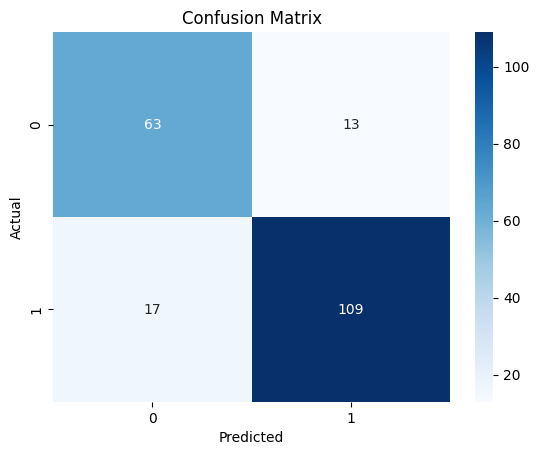

In [33]:
#Train Random Forest Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_res, y_train_res)
y_pred = model.predict(X_test)
# Evaluation Metrics and Confusion Matrix
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
# Confusion Matrix Heatmap
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Model Evaluation Summary

- **Accuracy:** 85.15% — The model correctly predicts delays or on-time shipments about 85% of the time.

- **Confusion Matrix:**

|               | Predicted No | Predicted Yes |
|---------------|--------------|---------------|
| Actual No     | 63           | 13            |
| Actual Yes    | 17           | 109           |

- **Key Metrics:**
  - **Precision (Delay = Yes):** 0.89 — When the model predicts a delay, it is correct 89% of the time.
  - **Recall (Delay = Yes):** 0.87 — The model detects 87% of actual delays.
  - **F1-Score (Delay = Yes):** 0.88 — Good balance between precision and recall for delays.
  - **Precision (No Delay):** 0.79 — Slightly less accurate when predicting no delay.
  - **Recall (No Delay):** 0.83 — Correctly identifies 83% of on-time shipments.

- **Summary:**  
  The model is better at detecting delayed shipments than non-delayed ones, which is important since missing delays can cause bigger issues than false alarms.


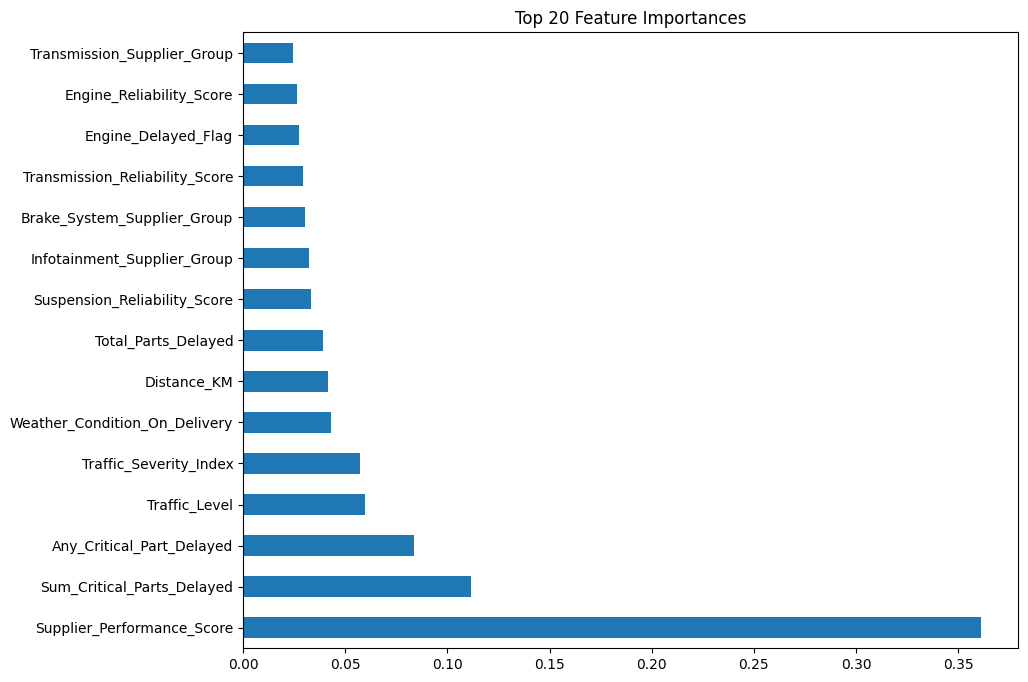

In [34]:
# Feature Importance
feat_imp = pd.Series(model.feature_importances_, index=X.columns)
feat_imp.nlargest(20).plot(kind='barh', figsize=(10,8))
plt.title("Top 20 Feature Importances")
plt.show()


### Saving the model

In [42]:
joblib.dump(model, 'random_forest_model_classification.pkl')

['random_forest_model_classification.pkl']

In [39]:
joblib.dump(top_15_features, 'top_features_classification.pkl')

['top_features_classification.pkl']

# Delay Classification Model - Summary

This notebook builds a machine learning model to predict whether a car shipment will be delayed or not, based on multiple features related to parts delivery, transport, weather, and order urgency.

### Data Preparation
- Loaded and cleaned dataset with relevant features.
- Encoded categorical variables using Label Encoding and Ordinal Encoding.
- Addressed class imbalance using SMOTE to oversample the minority class.

### Model Training
- Used a **Random Forest Classifier** with 100 trees for robust performance.
- Trained on the balanced dataset after oversampling.

### Evaluation Metrics
- Achieved **85.15% accuracy** on the test set.
- The model shows higher precision (89%) and recall (87%) for detecting delayed shipments.
- Confusion matrix indicates the model correctly identifies most delays with some false positives and false negatives.

### Feature Importance
- Top features influencing delay predictions include supplier groups, transport modes, and urgency levels.
- Visualized top 20 feature importances to understand which variables drive the model’s decisions.

### Conclusion
- The model effectively predicts shipment delays, prioritizing detection of delays over on-time predictions.
- Useful for supply chain teams to proactively manage risks and improve logistics planning.
- Further improvements can include hyperparameter tuning, incorporating more data, and testing other classification algorithms.
